# CIFAR-10 Image Classification Challenge

## *Power in Numbers: Leveraging the Benefits of Many Modern Strategies with Low Training Times and Simple Structures*

### Author: Sid Nagaich

Our goal is to create a convolutional neural network (CNN) to accurately classify images from the CIFAR-10 dataset. CIFAR-10 is one of the most widely used data sets used to train machine learning and computer vision models. The dataset contains 6,000 images of 10 classes - airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 

We take inspiration from some [well-performing models](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130), though [more modern strategies](https://paperswithcode.com/sota/image-classification-on-cifar-10) have been continually developed.

We will use Keras' functional API to implement our model. This gives us much more freedom than sequential models by allowing us to define an arbitrary connection structure between layers. For our purposes, this allows us to implement skip-connections. 

We will use batch normalization, convolution, max-pooling, and dropout layers in conjunction with variations of skip-connections and data augmentation to create an effective CNN. Benefits of such structures and strategies are discussed.

In [2]:
# import libraries
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Loading, splitting, and encoding the CIFAR-10 dataset
We will use a validation split within our test data during training. We also use one-hot encoding to encode the 10 categories of CIFAR-10.

In [3]:
# load CIFAR-10
(trainX, trainY), (testX, testY) = cifar10.load_data()
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

### Normalizing Pixel Values
We convert RGB pixel values (which have a range of 0-255) to values between 0 and 1.

In [4]:
# convert from integers to floats
train_norm = trainX.astype('float32')
test_norm = testX.astype('float32')
# normalize pixel value to range 0-1 (from 0-255)
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

### Defining the CNN Model
Our model uses standard convolutions to learn features of the images. We use batch normalization to standardizes the inputs to each layer. This stabilizes the learning process and reduces the amount of training required for our CNN. We also use max-pooling to emphasize prominent features and successively more prominent dropout layers to attempt to avoid overfitting on learned abstractions unique to the training data.

We explore the use of skip-connections (successfully used in ResNets) to take advantage of feature reusability. Since our layer is not as densly connected or deep as some other models, we added (rather than concatenated) our skip-connections. We actually find that our skip-connections do not lead to reasonable validation results during training, so we will later drop the intermediary skips in favor of only a single skip-connection from the beginning to just before the dense layer of the network. This is a potential area of interest for future optimization.

We use Keras' functional API to implement the model. This allows us to define a more complex model than a standard sequential model. We are particularly implementing skip connections. Skip connections are hypothesized to be useful here to both increase feature reusability and prevent issues of gradient explosion/vanishing caused by batch normalization. 

In [5]:
input = keras.Input(shape=(32, 32, 3), name="raw_img")

x = (Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(input)

full_skip = x
short_skip = x

x = (BatchNormalization())(x)
x = (Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (MaxPooling2D((2, 2)))(x)
x = (Dropout(0.1))(x)

short_skip = (MaxPooling2D((2, 2)))(short_skip)
x = layers.add([x,short_skip])

x = (Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (MaxPooling2D((2, 2)))(x)
x = (Dropout(0.15))(x)

short_skip = (MaxPooling2D((2, 2)))(short_skip)
short_skip = (Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(short_skip)
x = layers.add([x,short_skip])

x = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (MaxPooling2D((2, 2)))(x)
x = (Dropout(0.2))(x)

short_skip = (MaxPooling2D((2, 2)))(short_skip)
short_skip = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(short_skip)
x = layers.add([x,short_skip])

full_skip = (MaxPooling2D((8, 8)))(full_skip)
full_skip = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(full_skip)
x = layers.add([x,full_skip])

x = (Flatten())(x)
x = (Dense(128, activation='relu', kernel_initializer='he_uniform'))(x)
x = (BatchNormalization())(x)
x = (Dropout(0.25))(x)
output = (Dense(10, activation='softmax'))(x)

# make model
model = keras.Model(input, output, name="model")
# compile model
model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

### Training the Initial Model
Here, we are training the model. We use a 10% validation split and do not yet use any sort of data augmentation.

In [6]:
# first train on unmodified training data
steps = int(trainX.shape[0] / 64)
history = model.fit(trainX, trainY, epochs=20, validation_split=0.1, verbose=1)

Epoch 1/20
1407/1407 [==============================] - 51s 24ms/step - loss: 1.5858 - accuracy: 0.4345 - val_loss: 1.7649 - val_accuracy: 0.3158
Epoch 2/20
1407/1407 [==============================] - 31s 22ms/step - loss: 1.4264 - accuracy: 0.4858 - val_loss: 1.3107 - val_accuracy: 0.5562
Epoch 3/20
1407/1407 [==============================] - 30s 22ms/step - loss: 1.2050 - accuracy: 0.5704 - val_loss: 1.1274 - val_accuracy: 0.5982
Epoch 4/20
1407/1407 [==============================] - 30s 21ms/step - loss: 1.0429 - accuracy: 0.6370 - val_loss: 1.0801 - val_accuracy: 0.6210
Epoch 5/20
1407/1407 [==============================] - 30s 22ms/step - loss: 0.9288 - accuracy: 0.6759 - val_loss: 0.9680 - val_accuracy: 0.6696
Epoch 6/20
1407/1407 [==============================] - 31s 22ms/step - loss: 0.8422 - accuracy: 0.7095 - val_loss: 0.8913 - val_accuracy: 0.7016
Epoch 7/20
1407/1407 [==============================] - 38s 27ms/step - loss: 0.7590 - accuracy: 0.7389 - val_loss: 1.0839 -

### Evaluating the Model
We evaluate our trained model using the test data

In [7]:
# evaluate model
test_loss, test_acc = model.evaluate(testX,  testY, verbose=1)

313/313 [==============================] - 3s 11ms/step - loss: 1.0864 - accuracy: 0.7341


### Plotting Learning Curves
We can see a divergence occuring between the validation and training data in loss and accuracy, so our model appears to have overfit the training data before even the 10th epoch. We will use data augmentation in our next model to attempt to avoid this issue.

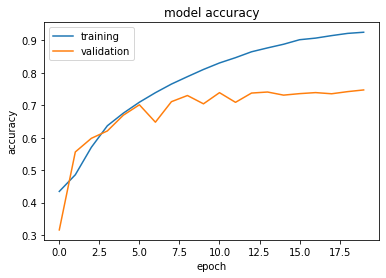

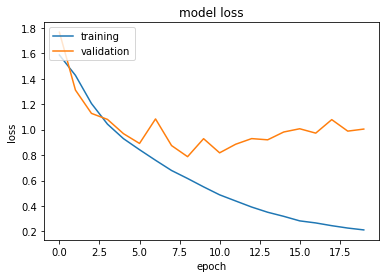

In [8]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

### Improving our model
We remove some of our skip layers to test effectiveness of other model structures. We used only the full skip to maximize feature reusability, as we are hypothesizing that our dense layer will mostly learn, through abstraction, the same information gained from the shorter skips.

After some brief testing, this model seems to have better results, so we will spend further time training.

In [12]:
input = keras.Input(shape=(32, 32, 3), name="raw_img")

x = (Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(input)

full_skip = x
'''
short_skip = x
'''

x = (BatchNormalization())(x)
x = (Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (MaxPooling2D((2, 2)))(x)
x = (Dropout(0.1))(x)

'''
short_skip = (MaxPooling2D((2, 2)))(short_skip)
x = layers.add([x,short_skip])
'''

x = (Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (MaxPooling2D((2, 2)))(x)
x = (Dropout(0.15))(x)

'''
short_skip = (MaxPooling2D((2, 2)))(short_skip)
short_skip = (Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(short_skip)
x = layers.add([x,short_skip])
'''

x = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(x)
x = (BatchNormalization())(x)
x = (MaxPooling2D((2, 2)))(x)
x = (Dropout(0.2))(x)

'''
short_skip = (MaxPooling2D((2, 2)))(short_skip)
short_skip = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(short_skip)
x = layers.add([x,short_skip])
'''

full_skip = (MaxPooling2D((8, 8)))(full_skip)
full_skip = (Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))(full_skip)
x = layers.add([x,full_skip])

x = (Flatten())(x)
x = (Dense(128, activation='relu', kernel_initializer='he_uniform'))(x)
x = (BatchNormalization())(x)
x = (Dropout(0.25))(x)
output = (Dense(10, activation='softmax'))(x)

# make model
model = keras.Model(input, output, name="model")
# compile model
model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

### Training and Data Augmentation
We saw that we quickly overfit the previous model, so we will use Data Augmentation to prevent this.

In [13]:
# first train on unmodified training data
steps = int(trainX.shape[0] / 64)
# future consideration: implement early stopping here
history = model.fit(trainX, trainY, epochs=8, validation_split=0.1, verbose=1) # 8 epochs because we observed overfitting here

# using data augmentation to prevent overfitting 
datagen = ImageDataGenerator(rotation_range=5,            # rotation
                             width_shift_range=0.2,       # horizontal shift
                             zoom_range=0.2,              # zoom
                             horizontal_flip=True,        # horizontal flip
                             brightness_range=[0.8,1.2])  # brightness
# prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=64)
# fit model again
steps = int(trainX.shape[0] / 64)
augmented_history = model.fit(it_train, steps_per_epoch=steps, epochs=25, validation_data=(testX, testY), verbose=1)

Epoch 1/8
1407/1407 [==============================] - 37s 25ms/step - loss: 1.4151 - accuracy: 0.4957 - val_loss: 1.1624 - val_accuracy: 0.5934
Epoch 2/8
1407/1407 [==============================] - 31s 22ms/step - loss: 0.9965 - accuracy: 0.6500 - val_loss: 1.1520 - val_accuracy: 0.6052
Epoch 3/8
1407/1407 [==============================] - 31s 22ms/step - loss: 0.8073 - accuracy: 0.7202 - val_loss: 0.7276 - val_accuracy: 0.7470
Epoch 4/8
1407/1407 [==============================] - 30s 21ms/step - loss: 0.6830 - accuracy: 0.7644 - val_loss: 0.6290 - val_accuracy: 0.7826
Epoch 5/8
1407/1407 [==============================] - 30s 21ms/step - loss: 0.5913 - accuracy: 0.7972 - val_loss: 0.6359 - val_accuracy: 0.7840
Epoch 6/8
1407/1407 [==============================] - 32s 23ms/step - loss: 0.5260 - accuracy: 0.8189 - val_loss: 0.5702 - val_accuracy: 0.8094
Epoch 7/8
1407/1407 [==============================] - 31s 22ms/step - loss: 0.4776 - accuracy: 0.8342 - val_loss: 0.5649 - val_ac

### Evaluating the Enhanced Model

In [14]:
# evaluate model
test_loss, test_acc = model.evaluate(testX,  testY, verbose=1)

313/313 [==============================] - 3s 9ms/step - loss: 0.4303 - accuracy: 0.8592


### Plot New Learning Curves
We see reduced overfitting and higher accuracies. We perhaps still see smaller amounts of overfitting. Implementing early stopping, variation of data augmentation, or different layer structures is a point of interest for future work.

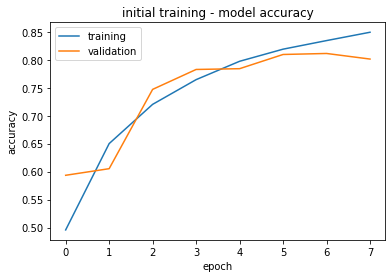

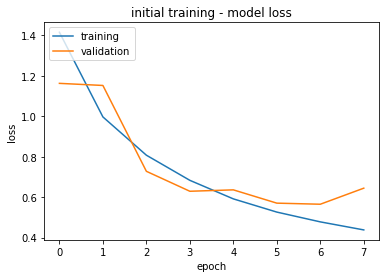

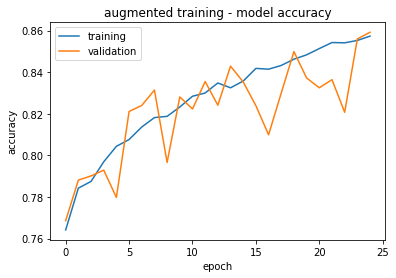

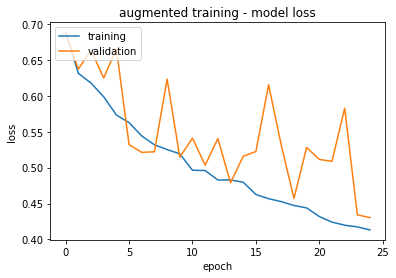

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('initial training - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('initial training - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# summarize history for accuracy for training on augmented data
plt.plot(augmented_history.history['accuracy'])
plt.plot(augmented_history.history['val_accuracy'])
plt.title('augmented training - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
# summarize history for loss for training on augmented data
plt.plot(augmented_history.history['loss'])
plt.plot(augmented_history.history['val_loss'])
plt.title('augmented training - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

### Closing remarks
I am generally happy with the results of the model. With such a simple structure, we were able to leverage the benefits of batch normalization, convolution, max-pooling, and dropout layers through the use of skip-connections and data augmentation. 

My immediate thoughts for the improvement of this model are to create a deeper and denser structure so as to leverage the benefits of the skip-connections that we previously removed. Nonetheless, the performance of the implemented model seems impressive given its simplicity and relatively low training times.